In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Bidirectional
from google.colab.patches import cv2_imshow
import cv2
import sys
import csv
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
import pickle
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from functools import reduce
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


LOAD LABELS DATASET

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Dataset Boxing.csv')

CREATE LABELS LIST FOR MULTICLASSIFICATION

In [ ]:
moves_per_video = 5
move_labels = []

viable_moves = df['Move Type'].unique()
viable_moves = viable_moves[:len(viable_moves)-3]
print(viable_moves)

for i in range(df.shape[0]):
  if df['Move Type'].iloc[i] in viable_moves:
    for j in range(moves_per_video):
      move_labels.append(df['Move Type'].iloc[i])

['ready stance' 'jab' 'cross' 'lead hook' 'rear hook' 'lead uppercut'
 'rear uppercut']
(560,)


NOMINAL TO CATEGORICAL

In [ ]:
# Converting labels from nominal values to binary categorical

y=[]

for i in range(len(move_labels)):
  for j in range(len(viable_moves)):
    if move_labels[i] == viable_moves[j]:
      y.append(j)

y_cat = to_categorical(y, num_classes=7)

for i, label in  enumerate(viable_moves):
    print(f"Binary line {i + 1} corresponds to label: {label}")

Binary line 1 corresponds to label: ready stance
Binary line 2 corresponds to label: jab
Binary line 3 corresponds to label: cross
Binary line 4 corresponds to label: lead hook
Binary line 5 corresponds to label: rear hook
Binary line 6 corresponds to label: lead uppercut
Binary line 7 corresponds to label: rear uppercut


LOAD THE LANDMARKS FILES

In [ ]:
# FRONT VIEW

with open('/content/gdrive/MyDrive/Landmarks/front/front_final_landmarks.pkl', 'rb') as file:
    front_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_1.5/front_1.5_final_landmarks.pkl', 'rb') as file:
    front_15_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_2/front_2_final_landmarks.pkl', 'rb') as file:
    front_2_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/front_4/front_4_final_landmarks.pkl', 'rb') as file:
    front_4_data = pickle.load(file)

In [ ]:
# SIDE VIEW

with open('/content/gdrive/MyDrive/Landmarks/side/side_final_landmarks.pkl', 'rb') as file:
    side_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_1.5/side_1.5_final_landmarks.pkl', 'rb') as file:
    side_15_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_2/side_2_final_landmarks.pkl', 'rb') as file:
    side_2_data = pickle.load(file)

with open('/content/gdrive/MyDrive/Landmarks/side_4/side_4_final_landmarks.pkl', 'rb') as file:
    side_4_data = pickle.load(file)

HELPING FUNCTIONS

In [ ]:
def train_validation_test_split(data, labels, random_state):
  "Function that splits the input data into training validation and testing sets given a specific random state seed"

  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random_state, stratify=labels)
  x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=random_state, stratify=y_test)

  x_train = np.array(x_train)
  x_test = np.array(x_test)
  x_validation = np.array(x_validation)

  return x_train, x_validation, x_test, y_train, y_validation, y_test

In [ ]:
def plot_average_train_valid_results(histories):
    "Function that plots the training and validation accuracy and loss over epochs"

    avg_loss = []
    avg_val_loss = []
    avg_accuracy = []
    avg_val_accuracy = []

    # Loop through each history object in the list
    for history in histories:
        avg_loss.append(history.history['loss'])
        avg_val_loss.append(history.history['val_loss'])
        avg_accuracy.append(history.history['accuracy'])
        avg_val_accuracy.append(history.history['val_accuracy'])

    # Calculate averages
    avg_loss = np.mean(avg_loss, axis=0)
    avg_val_loss = np.mean(avg_val_loss, axis=0)
    avg_accuracy = np.mean(avg_accuracy, axis=0)
    avg_val_accuracy = np.mean(avg_val_accuracy, axis=0)

    # Plot average training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(avg_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title('Average Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot average training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(avg_accuracy, label='Average Training Accuracy')
    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def average_accuracy_boxplots(metrics_list, title):
    "Function that plots the boxplot of accuracies"

    # Extract accuracy values from metrics_list
    accuracy_values = [metrics[0] for metrics in metrics_list]

    # Calculate average accuracy
    average_accuracy = sum(accuracy_values) / len(accuracy_values)

    # Print average accuracy
    print(f"Average Accuracy across Models: {average_accuracy}")

    # Create a boxplot for accuracy values
    sns.boxplot(y=accuracy_values)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.show()
    return accuracy_values

In [ ]:
def average_loss_boxplots(metrics_list, title):
    "Function that plots the boxplot of losses"

    # Extract loss values from metrics_list
    loss_values = [metrics[1] for metrics in metrics_list]

    # Calculate average loss
    average_loss = sum(loss_values) / len(loss_values)

    # Print average loss
    print(f"Average Loss across Models: {average_loss}")

    # Create a boxplot for loss values
    sns.boxplot(y=loss_values)
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Model')
    plt.show()
    return loss_values

In [ ]:
def calculate_average_class_report(metrics_lists):
    "Function that computes the average metrics Precision, Recall and F1-Score"

    classification_reports = [metrics[2] for metrics in metrics_lists]
    num_classes = len(classification_reports[0])
    num_runs = len(classification_reports)

    # Initialize lists to store sum of metrics for each class
    sum_precision = [0] * num_classes
    sum_recall = [0] * num_classes
    sum_f1 = [0] * num_classes

    # Sum up the metrics for each class across all runs
    for metrics_list in classification_reports:
        for i, metrics_dict in enumerate(metrics_list):
            sum_precision[i] += metrics_dict['Precision']
            sum_recall[i] += metrics_dict['Recall']
            sum_f1[i] += metrics_dict['F1 Score']

    # Calculate average metrics for each class
    avg_precision = [sum_p / num_runs for sum_p in sum_precision]
    avg_recall = [sum_r / num_runs for sum_r in sum_recall]
    avg_f1 = [sum_f / num_runs for sum_f in sum_f1]

    # Create a list of dictionaries for the average metrics
    avg_metrics_list = []
    for i in range(num_classes):
        avg_metrics_dict = {
            'Class': i + 1,
            'Average Precision': avg_precision[i],
            'Average Recall': avg_recall[i],
            'Average F1 Score': avg_f1[i]
        }
        avg_metrics_list.append(avg_metrics_dict)

    # Print the average metrics for each class
    for avg_metrics_dict in avg_metrics_list:
        print(f"Class {avg_metrics_dict['Class']}: Average Precision={avg_metrics_dict['Average Precision']:.4f}, Average Recall={avg_metrics_dict['Average Recall']:.4f}, Average F1 Score={avg_metrics_dict['Average F1 Score']:.4f}")

In [ ]:
def sum_confusion_matrix(metrics_list, title):
    " Function that computes the summed confusion matrix"

    # Extract confusion matrices from metrics_list
    confusion_matrices = [metrics[3] for metrics in metrics_list]

    # Calculate the sum of confusion matrices element-wise
    sum_confusion_matrix = np.sum(confusion_matrices, axis=0)

    # disp = ConfusionMatrixDisplay(average_confusion_matrix, display_labels=viable_moves)
    disp = ConfusionMatrixDisplay(sum_confusion_matrix, display_labels=viable_moves)

    disp.plot()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def evaluate_model(model, x_test, y_test):
  "Function that evaluates the testing set and returns a list with different metrics"

  loss,accuracy = model.evaluate(x_test,y_test)

  y_pred = []

  for i in model.predict(x_test):
      y_pred.append(np.argmax(np.array(i)).astype("int32"))

  y_test_reverted = np.argmax(y_test, axis=1)

# class_report = classification_report(y_test_reverted,y_pred, output_dict=True)
  precision = precision_score(y_test_reverted, y_pred, average=None)
  recall = recall_score(y_test_reverted, y_pred, average=None)
  f1 = f1_score(y_test_reverted, y_pred, average=None)

  class_report = []
  for i in range(len(precision)):
      metrics_dict = {
          'Class': i + 1,
          'Precision': precision[i],
          'Recall': recall[i],
          'F1 Score': f1[i]
      }
      class_report.append(metrics_dict)


  conf_matrix = confusion_matrix(y_test_reverted, y_pred)

  return accuracy, loss, class_report, conf_matrix

In [ ]:
def make_model(x_train, y_train):

  n_timesteps = np.shape(x_train)[1]
  n_features = np.shape(x_train)[2]
  n_outputs = np.shape(y_train)[1]

  model = Sequential()
  model.add(Masking(mask_value=-10, input_shape=(n_timesteps, n_features))) # a Masking layer before LSTM layer to ignore the padded timestamps,
  model.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps,n_features))) # Default activation="tanh", experiment with activation='relu'
  model.add(Dropout(0.2))
  model.add(LSTM(128)) # Default activation="tanh", experiment with activation='relu'
  model.add(Dropout(0.2)) # a dropout layer intended to reduce overfitting of the model to the training data
  model.add(Dense(64, activation='relu')) # experiment with this
  model.add(Dense(n_outputs, activation='softmax')) #'softmax' for multi-class

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
def save_model(model):
  model.save('/content/gdrive/MyDrive/side_model.keras')
  # function to save model

In [ ]:
def run_model(model, x_train, y_train, x_validation, y_validation):
  history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_validation,y_validation),verbose=0)
  return history

In [ ]:
def experiment(num_iterations, view):
  history_list = []
  metrics_list = []
  metrics_list_15 = []
  metrics_list_2 = []
  metrics_list_4 = []

  for i in range(num_iterations):
    if view == 'front':
      X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(front_data, y_cat, i)
      _, _, X_test15, _, _, y_test15 =  train_validation_test_split(front_15_data, y_cat, i)
      _, _, X_test2, _, _, y_test2 = train_validation_test_split(front_2_data, y_cat, i)
      _, _, X_test4, _, _, y_test4 = train_validation_test_split(front_4_data, y_cat, i)
    elif view == 'side':
      X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(side_data, y_cat, i)
      _, _, X_test15, _, _, y_test15 = train_validation_test_split(side_15_data, y_cat, i)
      _, _, X_test2, _, _, y_test2 = train_validation_test_split(side_2_data, y_cat, i)
      _, _, X_test4, _, _, y_test4 = train_validation_test_split(side_4_data, y_cat, i)

    model = make_model(X_train, y_train)
    history = run_model(model, X_train, y_train, X_validation, y_validation)
    history_list.append(history)
    metrics_list.append(list(evaluate_model(model, X_test, y_test)))
    metrics_list_15.append(list(evaluate_model(model, X_test15, y_test15)))
    metrics_list_2.append(list(evaluate_model(model, X_test2, y_test2)))
    metrics_list_4.append(list(evaluate_model(model, X_test4, y_test4)))

    print('\n Iteration ', i+1, " finished")

  save_model(model)

  plot_average_train_valid_results(history_list)


  accuracies = []
  losses = []

  print("\nResults for original quality\n")
  ac = average_accuracy_boxplots(metrics_list, 'Boxplot of Model Accuracies for videos of original quality')
  l = average_loss_boxplots(metrics_list, 'Boxplot of Model Losses for videos of original quality')
  accuracies.append(ac)
  losses.append(l)
  sum_confusion_matrix(metrics_list, 'Summed Confusion matrix for videos of original quality')
  # average_classification_report(metrics_list, 'Classification report for videos of original quality')
  calculate_average_class_report(metrics_list)

  print("\nResults for 1.5 times downgraded quality\n")
  ac = average_accuracy_boxplots(metrics_list_15, 'Boxplot of Model Accuracies for videos of 1.5 times downgraded quality')
  l = average_loss_boxplots(metrics_list_15, 'Boxplot of Model Losses for videos of 1.5 times downgraded quality')
  accuracies.append(ac)
  losses.append(l)
  sum_confusion_matrix(metrics_list_15, 'Summed Confusion matrix for videos of 1.5 times downgraded quality')
  # average_classification_report(metrics_list_15, 'Classification report for videos of 1.5 times downgraded quality')
  calculate_average_class_report(metrics_list_15)

  print("\nResults for 2 times downgraded quality\n")
  ac = average_accuracy_boxplots(metrics_list_2, 'Boxplot of Model Accuracies for videos of 1.5 times downgraded quality')
  l = average_loss_boxplots(metrics_list_2, 'Boxplot of Model Losses for videos of 2 times downgraded quality')
  accuracies.append(ac)
  losses.append(l)
  sum_confusion_matrix(metrics_list_2, 'Summed Confusion matrix for videos of 2 times downgraded quality')
  # average_classification_report(metrics_list_2, 'Classification report for videos of 2 times downgraded quality')
  calculate_average_class_report(metrics_list_2)

  print("\nResults for 4 times downgraded quality\n")
  ac = average_accuracy_boxplots(metrics_list_4, 'Boxplot of Model Accuracies for videos of 4 times downgraded quality')
  l = average_loss_boxplots(metrics_list_4, 'Boxplot of Model Losses for videos of 4 times downgraded quality')
  accuracies.append(ac)
  losses.append(l)
  sum_confusion_matrix(metrics_list_4, 'Summed Confusion matrix for videos of 4 times downgraded quality')
  # average_classification_report(metrics_list_4, 'Classification report for videos of 4 times downgraded quality')
  calculate_average_class_report(metrics_list_4)


  anton = list([accuracies, losses])
  with open(f'./gdrive/MyDrive/side_anton.pkl', 'wb') as file:
    pickle.dump(anton, file)


MAIN

2/2 [==============================] - 0s 9ms/step

 Iteration  1  finished


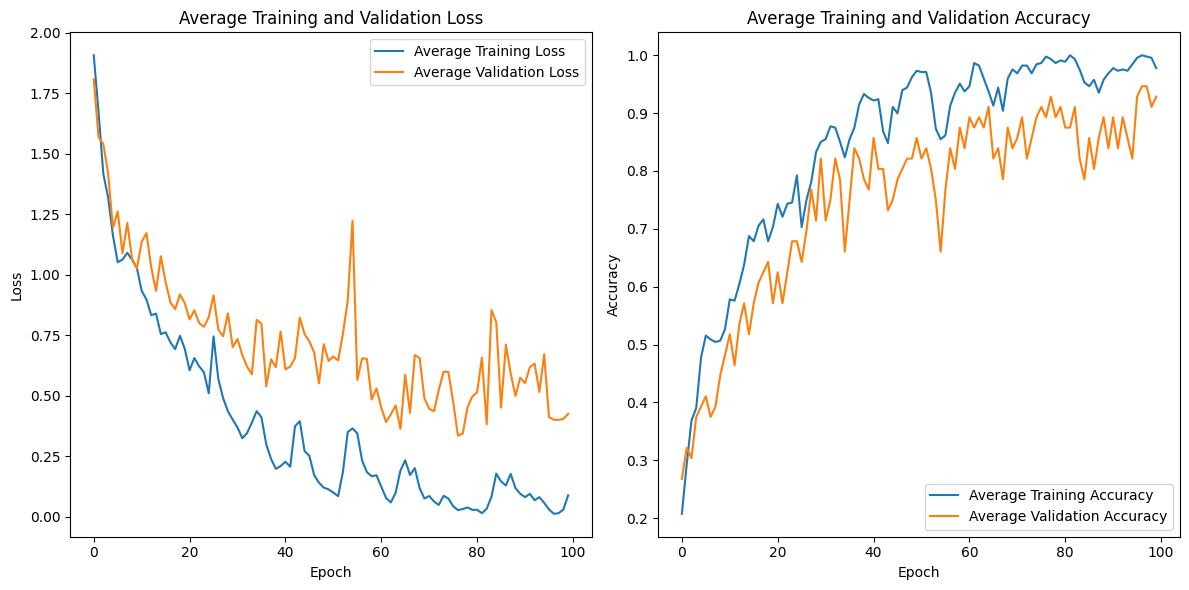


Results for original quality

Average Accuracy across Models: 0.875


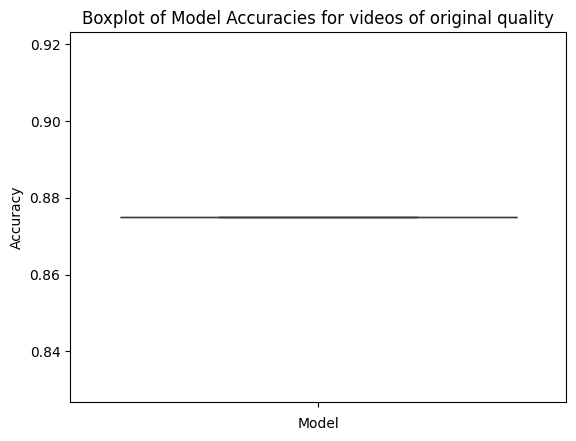

Average Loss across Models: 0.4298691749572754


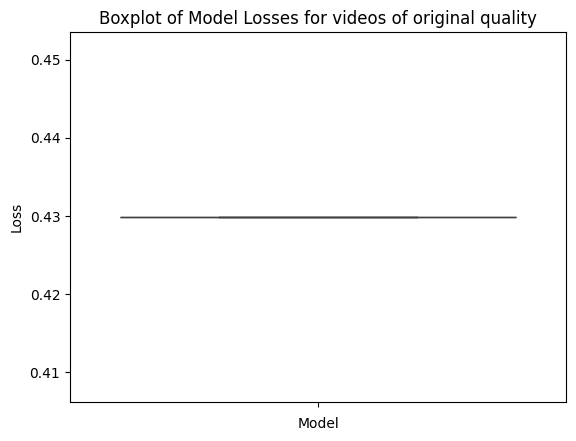

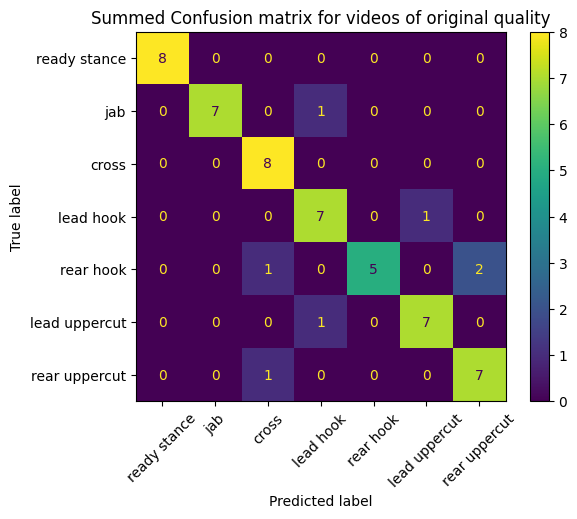

Class 1: Average Precision=1.0000, Average Recall=1.0000, Average F1 Score=1.0000
Class 2: Average Precision=1.0000, Average Recall=0.8750, Average F1 Score=0.9333
Class 3: Average Precision=0.8000, Average Recall=1.0000, Average F1 Score=0.8889
Class 4: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235
Class 5: Average Precision=1.0000, Average Recall=0.6250, Average F1 Score=0.7692
Class 6: Average Precision=0.8750, Average Recall=0.8750, Average F1 Score=0.8750
Class 7: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235

Results for 1.5 times downgraded quality

Average Accuracy across Models: 0.8214285969734192


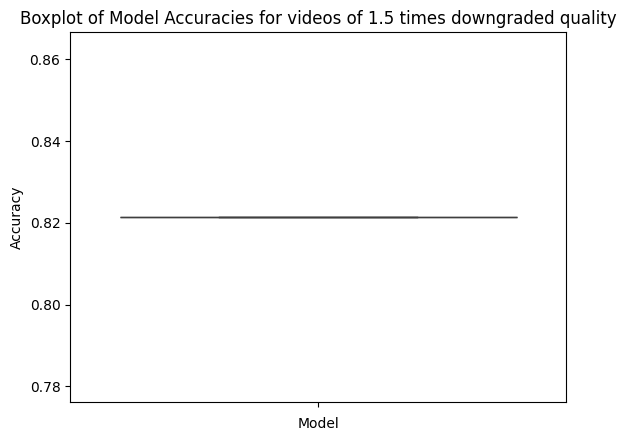

Average Loss across Models: 0.47144511342048645


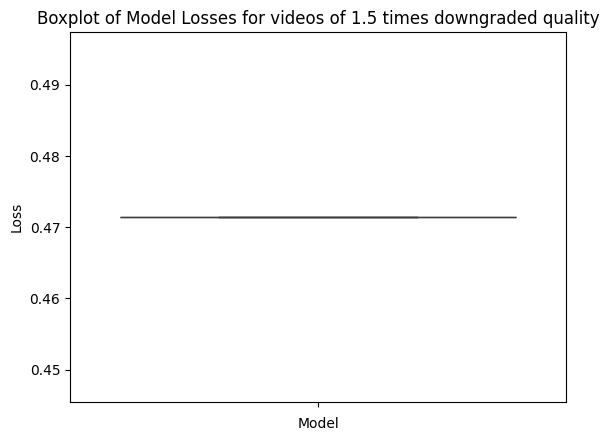

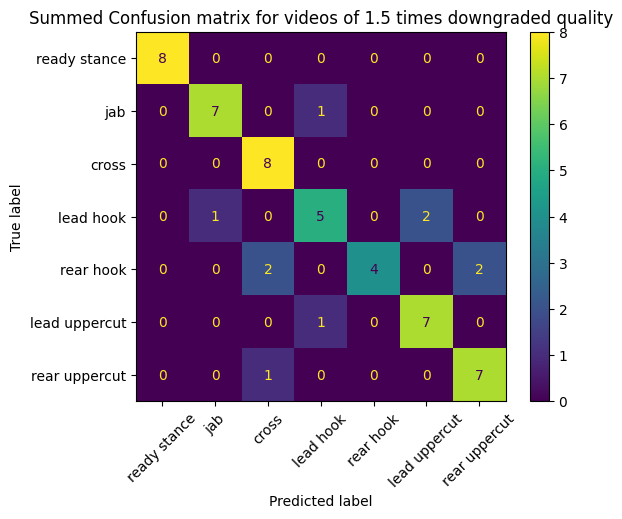

Class 1: Average Precision=1.0000, Average Recall=1.0000, Average F1 Score=1.0000
Class 2: Average Precision=0.8750, Average Recall=0.8750, Average F1 Score=0.8750
Class 3: Average Precision=0.7273, Average Recall=1.0000, Average F1 Score=0.8421
Class 4: Average Precision=0.7143, Average Recall=0.6250, Average F1 Score=0.6667
Class 5: Average Precision=1.0000, Average Recall=0.5000, Average F1 Score=0.6667
Class 6: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235
Class 7: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235

Results for 2 times downgraded quality

Average Accuracy across Models: 0.8571428656578064


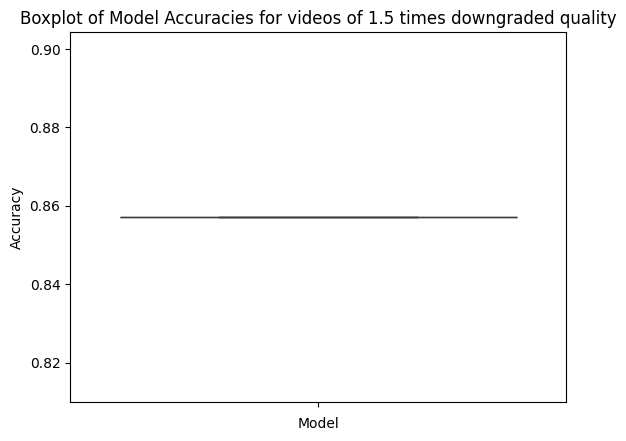

Average Loss across Models: 0.501503586769104


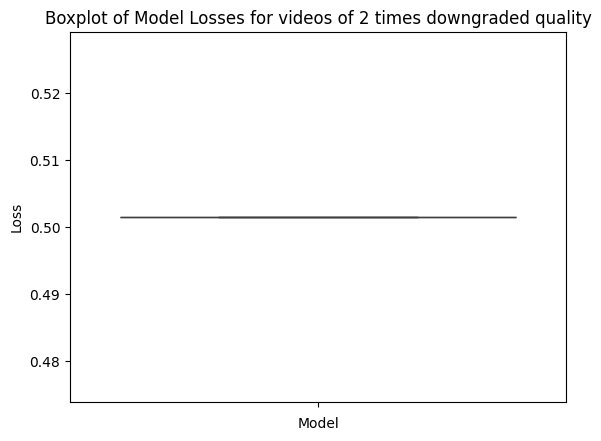

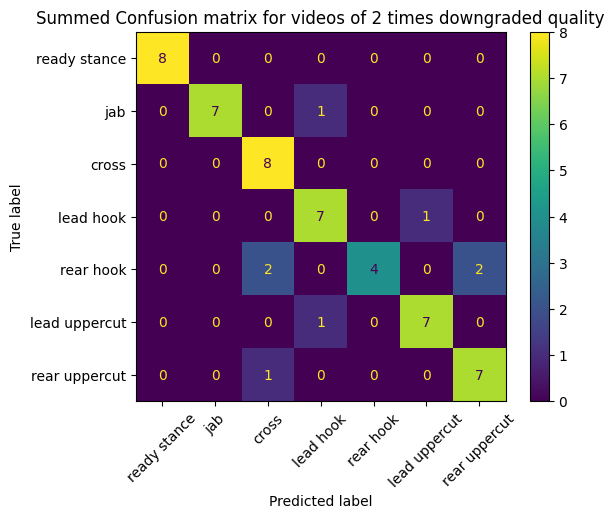

Class 1: Average Precision=1.0000, Average Recall=1.0000, Average F1 Score=1.0000
Class 2: Average Precision=1.0000, Average Recall=0.8750, Average F1 Score=0.9333
Class 3: Average Precision=0.7273, Average Recall=1.0000, Average F1 Score=0.8421
Class 4: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235
Class 5: Average Precision=1.0000, Average Recall=0.5000, Average F1 Score=0.6667
Class 6: Average Precision=0.8750, Average Recall=0.8750, Average F1 Score=0.8750
Class 7: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235

Results for 4 times downgraded quality

Average Accuracy across Models: 0.8571428656578064


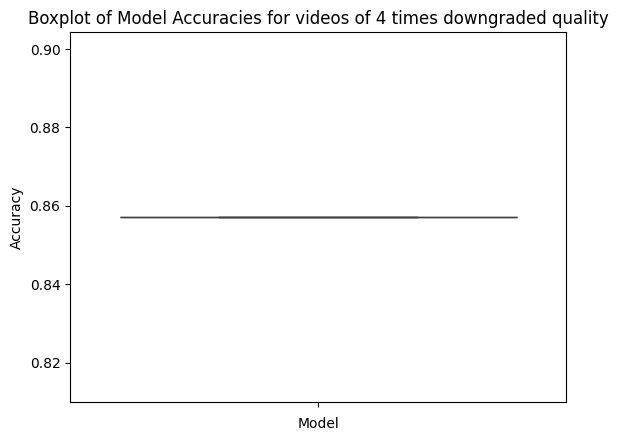

Average Loss across Models: 0.6522278189659119


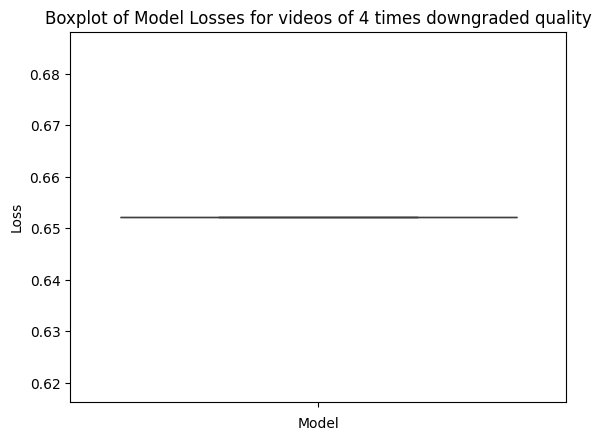

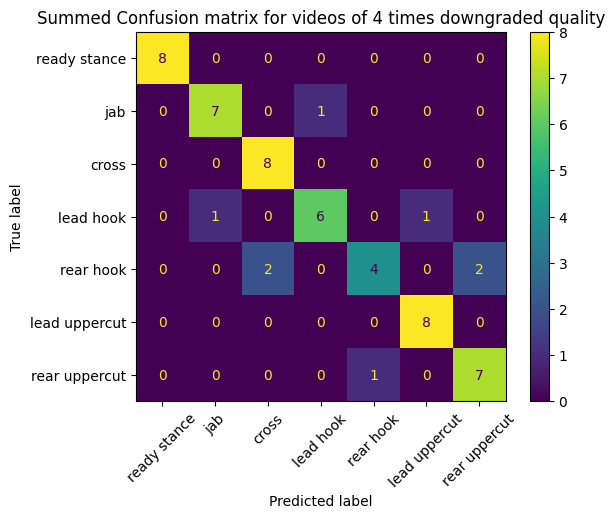

Class 1: Average Precision=1.0000, Average Recall=1.0000, Average F1 Score=1.0000
Class 2: Average Precision=0.8750, Average Recall=0.8750, Average F1 Score=0.8750
Class 3: Average Precision=0.8000, Average Recall=1.0000, Average F1 Score=0.8889
Class 4: Average Precision=0.8571, Average Recall=0.7500, Average F1 Score=0.8000
Class 5: Average Precision=0.8000, Average Recall=0.5000, Average F1 Score=0.6154
Class 6: Average Precision=0.8889, Average Recall=1.0000, Average F1 Score=0.9412
Class 7: Average Precision=0.7778, Average Recall=0.8750, Average F1 Score=0.8235


In [ ]:
num_of_iterations = 1
experiment(num_of_iterations, 'side')